# Time Series Forecasting via Holt-Winters Additive Method

In [1]:
# importing the required libraries

import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# reading the dataset

data = pd.read_excel("DATASET for TIME SERIES (BCCL REVENUE).xlsx")
data = data[data['Fiscal_Year'] != 2020]
data.drop(['BCCLVOL-KSCM','Fiscal_Year'],axis = 1,inplace = True)
data = data[data['Print_NonPrint'] == 'Print']
data = data[data["BCCLREV-LAC"] > 0]
data

,Calendar_Date,Calendar_month_Description,Print_NonPrint,BCCLREV-LAC
0,2019-11-20,November,Print,994.369479
3,2017-01-16,January,Print,763.204833
5,2015-02-02,February,Print,916.128737
6,2019-01-30,January,Print,1443.475949
7,2016-01-10,January,Print,1216.198645
...,...,...,...,...
6517,2013-06-24,June,Print,1076.607182
6519,2013-12-27,December,Print,1131.303373
6520,2014-01-28,January,Print,1403.906246
6523,2013-11-03,November,Print,691.062545


In [3]:
# sorting the data

data.sort_values(by = "Calendar_Date",inplace = True)
data['Calendar_Date'] = data['Calendar_Date'].astype('datetime64[M]')
data

,Calendar_Date,Calendar_month_Description,Print_NonPrint,BCCLREV-LAC
5890,2012-04-01,April,Print,5.812530
6098,2012-04-01,April,Print,1.030833
5762,2012-04-01,April,Print,0.171182
5961,2012-04-01,April,Print,0.009705
5688,2012-04-01,April,Print,0.544760
...,...,...,...,...
1233,2021-09-01,September,Print,818.541705
3508,2021-09-01,September,Print,760.461106
1730,2021-09-01,September,Print,506.053946
2107,2021-09-01,September,Print,1014.200998


In [4]:
# time series

data = data.groupby('Calendar_Date').sum().reset_index()
data = data.set_index('Calendar_Date')
data

,BCCLREV-LAC
Calendar_Date,
2012-04-01,7.637243
2012-05-01,3.406902
2012-06-01,0.410186
2012-07-01,3.471025
2012-08-01,7.438260
...,...
2021-05-01,7629.075998
2021-06-01,14003.168246
2021-07-01,20655.889626


### Outlier Analysis

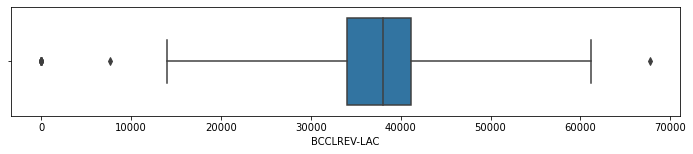

In [5]:
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=data['BCCLREV-LAC'],whis=3.5)

In [6]:
# Outlier Treatment

Q1 = data['BCCLREV-LAC'].quantile(0.99)
data['BCCLREV-LAC'][data['BCCLREV-LAC']>=Q1] = Q1

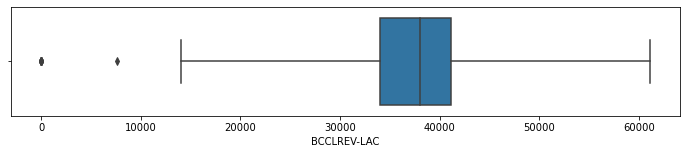

In [7]:
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=data['BCCLREV-LAC'],whis=3.5)

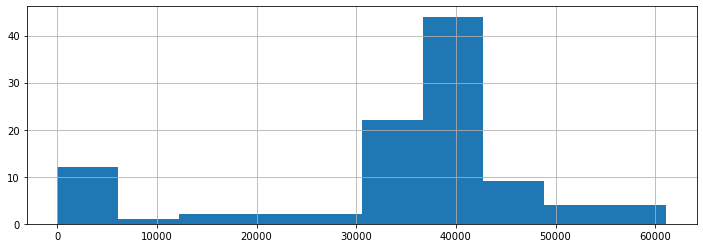

In [8]:
fig = data['BCCLREV-LAC'].hist(figsize = (12,4))

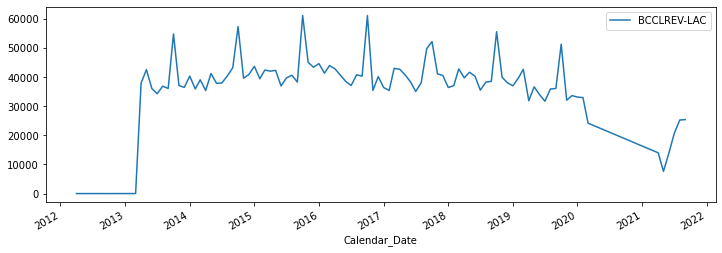

In [9]:
# plotting the time series

data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.show(block=False)

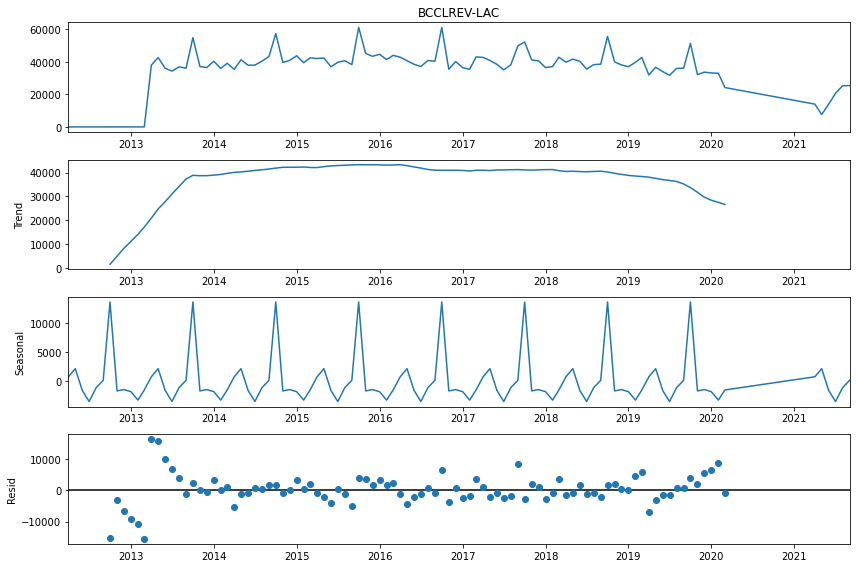

In [10]:
# decomposing the time series

from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data['BCCLREV-LAC'], model='additive',period = 12) # additive seasonal index
fig = decomposition.plot()
plt.show()

In [11]:
# predicting for 2021-09-01

train_len = 101
train = data[0:train_len] 
test = data[train_len:]

In [12]:
# running the Holt-Winters Additive algorithm

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['BCCLREV-LAC']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(1)

{'smoothing_level': 0.7828571428571429, 'smoothing_trend': 0.03131428571428572, 'smoothing_seasonal': 0.21714285714285708, 'damping_trend': nan, 'initial_level': 31817.722673944438, 'initial_trend': 3244.3893120333337, 'initial_seasons': array([-31810.08543094, -31814.31577244, -31817.31248754, -31814.25164864,
       -31810.28441434, -31817.06755394, -31815.88342984, -31813.72987144,
       -31817.33957494, -31807.68959234, -31810.41832654, -31805.26322274]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


C:\Users\91888\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


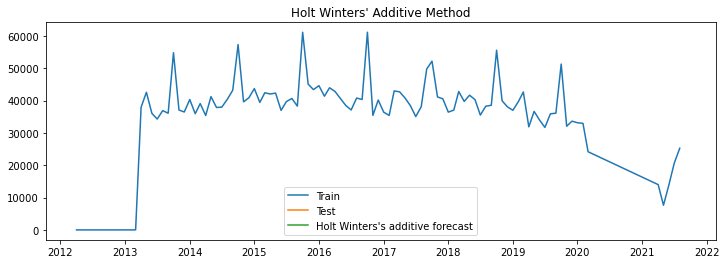

In [13]:
plt.figure(figsize=(12,4))
plt.plot( train['BCCLREV-LAC'], label='Train')
plt.plot(test['BCCLREV-LAC'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

In [14]:
# 2021-09-01 forecast

forecast = y_hat_hwa['hw_forecast']
forecast

Calendar_Date
2021-09-01    25108.336528
Name: hw_forecast, dtype: float64

In [15]:
# error metric

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['BCCLREV-LAC'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['BCCLREV-LAC']-y_hat_hwa['hw_forecast'])/test['BCCLREV-LAC'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
tempResults

,Method,RMSE,MAPE
0,Holt Winters' additive method,277.6,1.09
